# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q catboost shap

In [ ]:
import os 
os.chdir("/content/drive/MyDrive/UmojaHack Africa 2023: Carbon Dioxide Prediction Challenge (BEGINNER)/Data")

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from catboost import Pool
from catboost import MetricVisualizer

import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from collections import Counter

import random

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

In [ ]:
random.seed(2023)
np.random.seed(2023)

# Data

In [ ]:
sorted(os.listdir())

['SampleSubmission.csv', 'Test.csv', 'Train.csv', 'catboost_info']

In [ ]:
ss, test, train = [pd.read_csv(f"{f}") for f in sorted(os.listdir())[:3]]

# Basic EDA

In [ ]:
ss.head(2)

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0


In [ ]:
train.head(2)

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73,28.77,2019,1,0.000167,0.713172,0.000102,0.223929,24.939440,...,5566.222019,54826.032616,4606.209995,19.115282,0.353778,24.951948,49.053953,-89.638032,17.988874,86.05170
1,ID_-23.73_28.77_2019_2,-23.73,28.77,2019,2,-0.000155,0.812910,-0.000137,0.080281,16.624162,...,3711.511365,68491.753342,3034.461661,12.218664,0.244987,4.708856,42.586683,-89.904314,22.773246,88.87567


In [ ]:
test.head(2)

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53,27.47,2019,1,0.000077,0.454468,0.000034,0.114291,-80.286309,...,74897.052000,2180.266538,81287.074479,1562.031017,10.734123,0.280660,-31.230174,33.337966,-93.217261,23.358251
1,ID_-23.53_27.47_2019_2,-23.53,27.47,2019,2,0.000181,0.423171,0.000062,0.075100,-17.765690,...,84222.653521,982.619057,90307.650011,927.111222,5.250020,0.238933,66.490898,58.137794,-85.001467,13.416481


In [ ]:
train.columns.difference(test.columns)

Index(['emission'], dtype='object')

# Splitting data

In [ ]:
features = train.select_dtypes(["int", "float"]).columns.intersection(test.select_dtypes(["int", "float"]).columns).tolist()
features

['latitude',
 'longitude',
 'year',
 'week_no',
 'SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_sensor_azimuth_angle',
 'SulphurDioxide_sensor_zenith_angle',
 'SulphurDioxide_solar_azimuth_angle',
 'SulphurDioxide_solar_zenith_angle',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_sensor_azimuth_angle',
 'CarbonMonoxide_sensor_zenith_angle',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure'

In [ ]:
target = "emission"

In [ ]:
train.select_dtypes("object")

,ID_LAT_LON_YEAR_WEEK
0,ID_-23.73_28.77_2019_1
1,ID_-23.73_28.77_2019_2
2,ID_-23.73_28.77_2019_3
3,ID_-23.73_28.77_2019_4
4,ID_-23.73_28.77_2019_5
...,...
74000,ID_-33.93_25.67_2022_45
74001,ID_-33.93_25.67_2022_46
74002,ID_-33.93_25.67_2022_47
74003,ID_-33.93_25.67_2022_48


In [ ]:
train.isna().sum()[train.isna().sum()!=0]

In [ ]:
X, y = train[features], train[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print("Number of samples in X_train dataset: ", X_train.shape) 
print("Number of samples in y_train dataset: ", y_train.shape) 
print("Number of samples in X_test dataset: ", X_test.shape) 
print("Number of samples in y_test dataset: ", y_test.shape)

Number of samples in X_train dataset:  (59204, 74)
Number of samples in y_train dataset:  (59204,)
Number of samples in X_test dataset:  (14801, 74)
Number of samples in y_test dataset:  (14801,)


In [ ]:
train_pool = Pool(
    data=X_train, 
    label=y_train
)

# create validation_pool object
validation_pool = Pool(
    data=X_test, 
    label=y_test
)

# Train model

In [ ]:
# pretty basic model, max_depth=10 give slightly better results
cbs = CatBoostRegressor(iterations=4000,
                         learning_rate=0.012,
                         loss_function='RMSE',
                         max_depth=10, 
                         early_stopping_rounds=200,
                        #  task_type = "GPU",
                        #  cat_features = cat_features
                        )

# we are passing categorical features as parameters here
cbs.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=500,
    plot=True 
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 52635.0844349	test: 49668.9992867	best: 49668.9992867 (0)	total: 303ms	remaining: 20m 10s
500:	learn: 6370.2668500	test: 7167.6951269	best: 7167.6951269 (500)	total: 2m 54s	remaining: 20m 17s
1000:	learn: 3690.5666152	test: 4748.5393092	best: 4748.5393092 (1000)	total: 5m 27s	remaining: 16m 21s
1500:	learn: 2808.8024600	test: 4151.5261928	best: 4151.5110407 (1499)	total: 8m 8s	remaining: 13m 33s
2000:	learn: 2340.4398267	test: 3908.7125275	best: 3908.7014434 (1999)	total: 10m 53s	remaining: 10m 52s


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Assess model

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

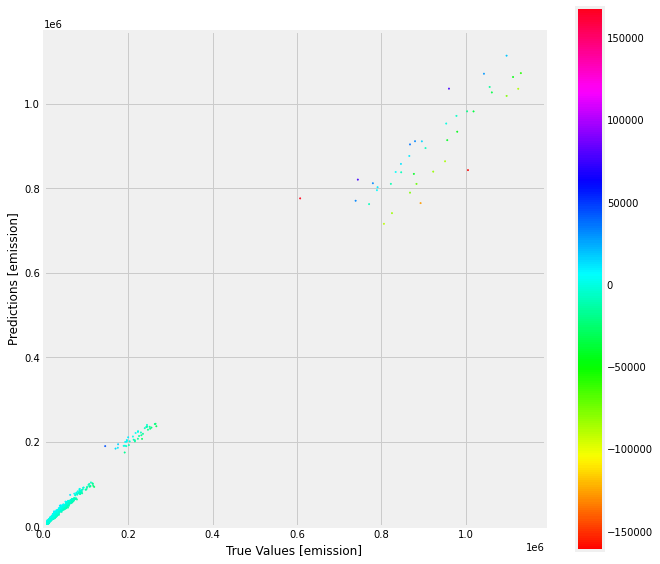

In [ ]:
test_predictions = cbs.predict(X_test).flatten()

error = (test_predictions - y_test)

plt.figure(figsize=(10,10))
plt.scatter(y_test, 
            test_predictions, 
            c=error,
            s=1.9,
            cmap='hsv'
            )
plt.colorbar()
plt.xlabel('True Values [emission]')
plt.ylabel('Predictions [emission]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.show()

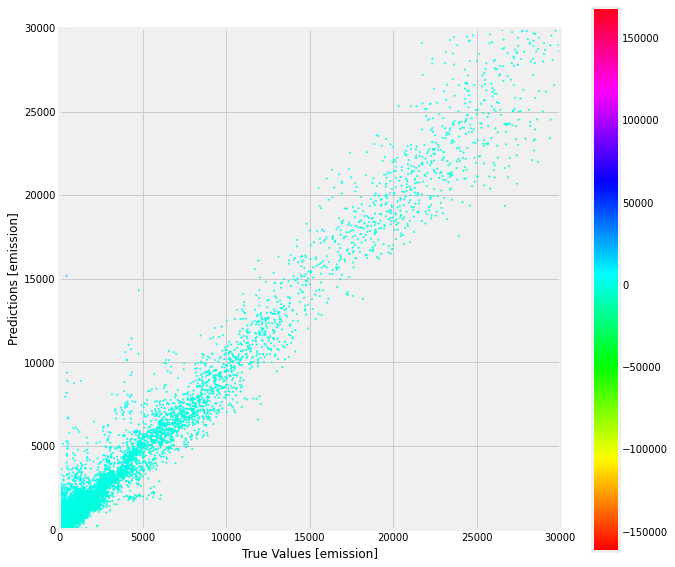

In [ ]:
error = test_predictions - y_test
# print(type(error))

plt.figure(figsize=(10,10))
plt.scatter(y_test, 
            test_predictions, 
            c=error,
            s=2,
            cmap='hsv',
            )
plt.colorbar()
plt.xlabel('True Values [emission]')
plt.ylabel('Predictions [emission]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, 30000])
plt.ylim([0, 30000])
plt.show()

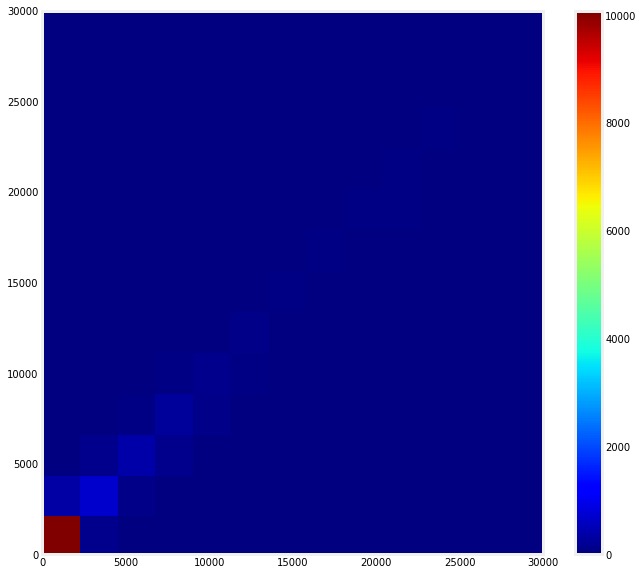

In [ ]:
plt.figure(figsize=(10,10))
plt.hist2d(y_test, test_predictions, (500,500),cmap=plt.cm.jet)
plt.colorbar()
plt.xlim([0, 30000])
plt.ylim([0, 30000])
plt.show()

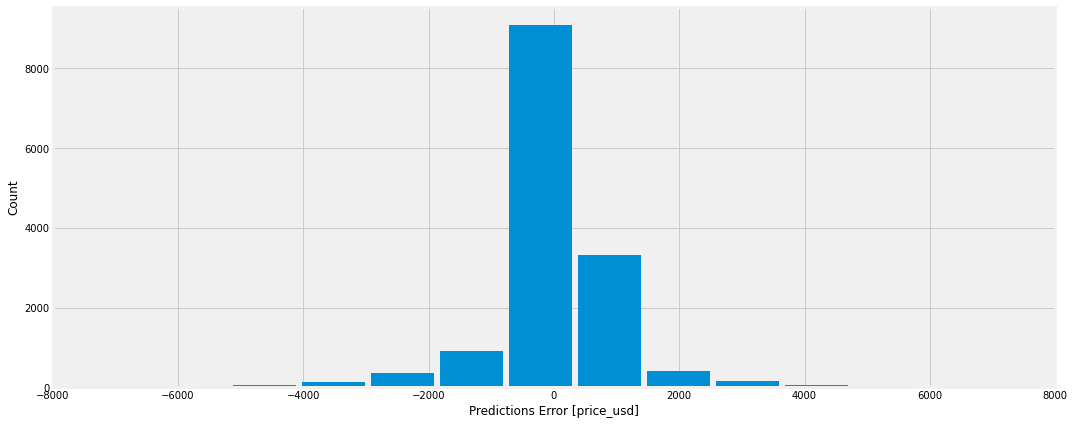

In [ ]:
plt.figure(figsize=(16,7))
plt.hist(error, bins = 300, rwidth=0.9)
plt.xlabel('Predictions Error [emission]')
_ = plt.ylabel('Count')
plt.xlim([-8000, 8000])
plt.show()

In [ ]:
%%time

importance_types = ['PredictionValuesChange',
                    'LossFunctionChange'
                   ]


for importance_type in importance_types:
    print(importance_type)
    print(cbs.get_feature_importance(data=train_pool, 
                                     type=importance_type))
    print('\n\n\n\n')

PredictionValuesChange
[4.41300589e+01 5.41291106e+01 5.57229089e-02 5.14308344e-02
 1.28694910e-02 1.29364694e-02 6.11985150e-03 1.92850226e-03
 2.81277387e-03 8.53631597e-03 6.56735181e-03 3.05793392e-02
 5.65883426e-03 1.29425152e-02 2.23892098e-02 8.98566712e-03
 1.81060949e-02 3.90339527e-03 1.53914809e-03 4.35217715e-02
 2.98462717e-02 5.14223949e-01 2.56074980e-01 4.69655605e-02
 3.49178823e-02 2.98161662e-03 1.81612404e-02 7.00935756e-03
 2.02587397e-02 2.36057323e-03 8.03824937e-04 2.38887722e-02
 2.33621106e-02 3.40395352e-03 1.77963697e-02 6.32118987e-03
 3.59352514e-03 3.31719473e-02 9.67356882e-03 1.52238878e-03
 5.29203983e-03 8.59398837e-03 9.99731647e-02 3.45814045e-03
 2.86487549e-03 3.18940706e-02 1.79813497e-02 5.32733170e-03
 5.63116485e-03 4.60965699e-03 3.16772558e-03 1.80344055e-03
 4.39046100e-03 1.51729161e-03 4.74613156e-02 2.33324301e-02
 2.28305440e-04 3.50126935e-03 9.12040088e-04 2.52223951e-04
 5.23077860e-03 1.94503337e-04 1.29963084e-03 7.12609435e-03
 

In [ ]:
%%time

import shap
shap.initjs()

shap_values = cbs.get_feature_importance(Pool(X_test, 
                                              label=y_test,
                                              # cat_features=cat_features
                                              ), 
                                         type="ShapValues")
print(type(shap_values))

expected_value = shap_values[0,-1]
print(expected_value)

shap_values = shap_values[:,:-1]

<class 'numpy.ndarray'>
7940.925704828353
CPU times: user 13min 6s, sys: 3.38 s, total: 13min 10s
Wall time: 7min 28s


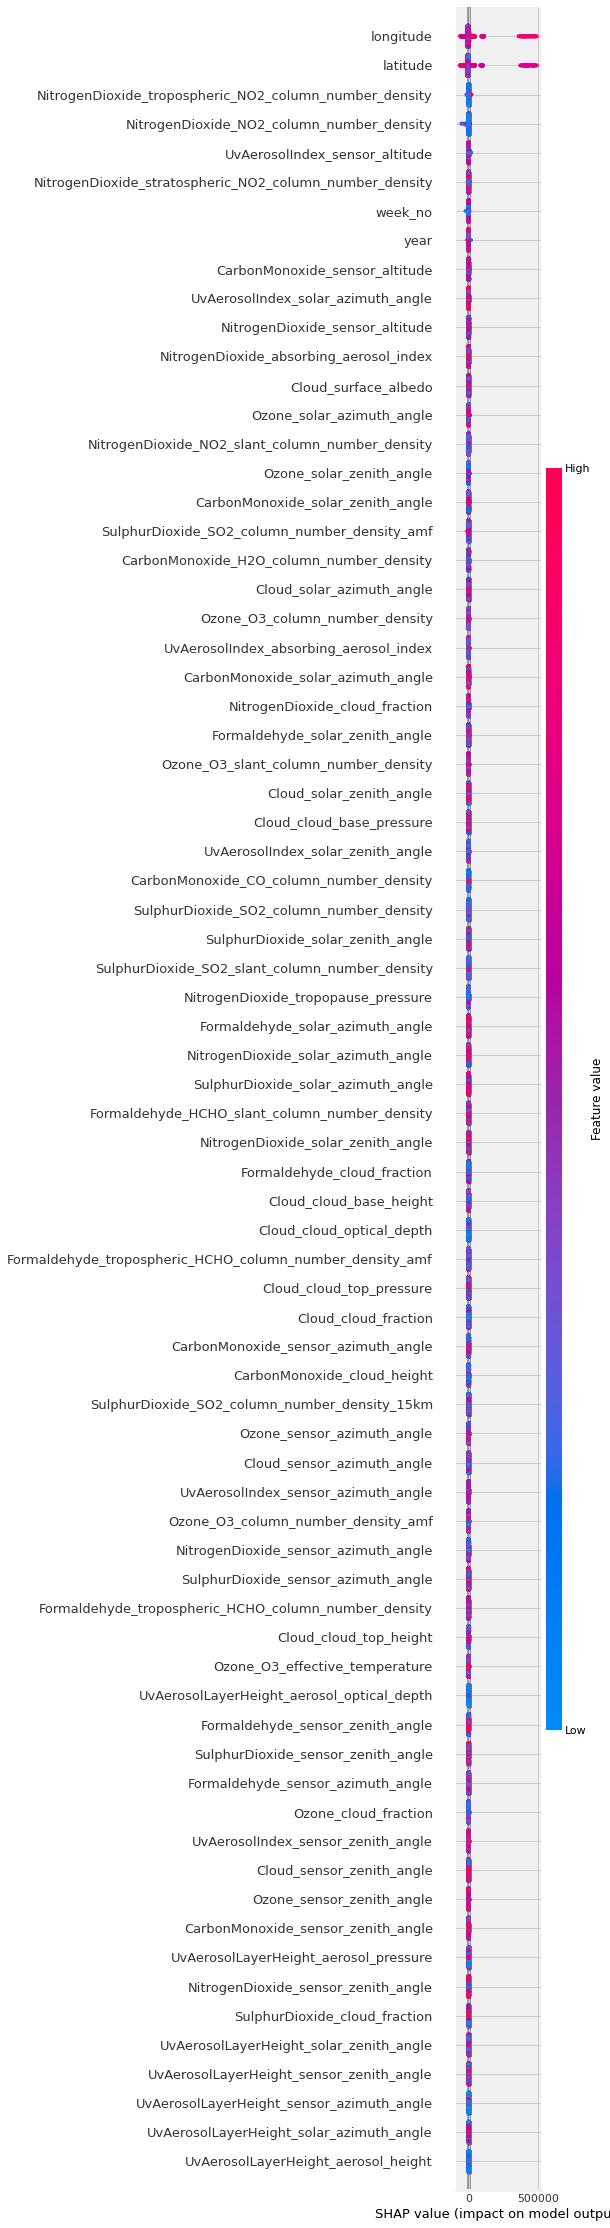

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

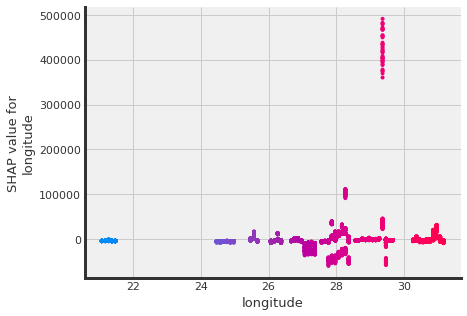

In [ ]:
shap.dependence_plot(ind='longitude', 
                     interaction_index='longitude',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

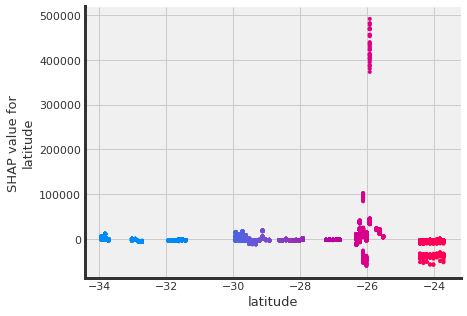

In [ ]:
shap.dependence_plot(ind='latitude', 
                     interaction_index='latitude',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.initjs()
for i in range(20,30):
    print('Sample', i, 'from the test set:')
    display(shap.force_plot(expected_value, shap_values[i,:], X_test.iloc[i,:]))
    print('Listed_price -------------------------------------->', y_test.iloc[i])
    print('parameters:\n', X_test.iloc[i,:])
    print('\n\n\n\n\n\n\n')

Sample 20 from the test set:


Listed_price --------------------------------------> 1423.29
parameters:
 latitude                                     -24.330000
longitude                                     29.270000
year                                        2021.000000
week_no                                       47.000000
SulphurDioxide_SO2_column_number_density       0.000246
                                               ...     
Cloud_surface_albedo                           0.247315
Cloud_sensor_azimuth_angle                   -41.248977
Cloud_sensor_zenith_angle                     47.128092
Cloud_solar_azimuth_angle                    -88.958671
Cloud_solar_zenith_angle                      28.984564
Name: 13475, Length: 74, dtype: float64








Sample 21 from the test set:


Listed_price --------------------------------------> 481.27115
parameters:
 latitude                                     -31.930000
longitude                                     28.570000
year                                        2019.000000
week_no                                       26.000000
SulphurDioxide_SO2_column_number_density       0.000424
                                               ...     
Cloud_surface_albedo                           0.230758
Cloud_sensor_azimuth_angle                   -11.721276
Cloud_sensor_zenith_angle                     58.553481
Cloud_solar_azimuth_angle                    -28.506251
Cloud_solar_zenith_angle                      62.265555
Name: 69110, Length: 74, dtype: float64








Sample 22 from the test set:


Listed_price --------------------------------------> 116.07278
parameters:
 latitude                                     -29.930000
longitude                                     30.570000
year                                        2019.000000
week_no                                        2.000000
SulphurDioxide_SO2_column_number_density      -0.000143
                                               ...     
Cloud_surface_albedo                           0.299303
Cloud_sensor_azimuth_angle                   -13.712206
Cloud_sensor_zenith_angle                     36.783392
Cloud_solar_azimuth_angle                    -78.867989
Cloud_solar_zenith_angle                      26.947232
Name: 60476, Length: 74, dtype: float64








Sample 23 from the test set:


Listed_price --------------------------------------> 4244.8125
parameters:
 latitude                                     -29.630000
longitude                                     30.670000
year                                        2020.000000
week_no                                       35.000000
SulphurDioxide_SO2_column_number_density       0.000106
                                               ...     
Cloud_surface_albedo                           0.163530
Cloud_sensor_azimuth_angle                    31.328033
Cloud_sensor_zenith_angle                     47.818388
Cloud_solar_azimuth_angle                    -33.236105
Cloud_solar_zenith_angle                      45.905184
Name: 54616, Length: 74, dtype: float64








Sample 24 from the test set:


Listed_price --------------------------------------> 38.37607
parameters:
 latitude                                     -28.330000
longitude                                     21.470000
year                                        2022.000000
week_no                                       11.000000
SulphurDioxide_SO2_column_number_density      -0.000383
                                               ...     
Cloud_surface_albedo                           0.238996
Cloud_sensor_azimuth_angle                   -15.355780
Cloud_sensor_zenith_angle                     60.743572
Cloud_solar_azimuth_angle                    -45.242166
Cloud_solar_zenith_angle                      38.288598
Name: 41166, Length: 74, dtype: float64








Sample 25 from the test set:


Listed_price --------------------------------------> 3882.66
parameters:
 latitude                                     -31.530000
longitude                                     28.870000
year                                        2019.000000
week_no                                       18.000000
SulphurDioxide_SO2_column_number_density       0.000015
                                               ...     
Cloud_surface_albedo                           0.263835
Cloud_sensor_azimuth_angle                   -10.450332
Cloud_sensor_zenith_angle                     54.731800
Cloud_solar_azimuth_angle                    -33.402462
Cloud_solar_zenith_angle                      55.323021
Name: 63977, Length: 74, dtype: float64








Sample 26 from the test set:


Listed_price --------------------------------------> 54396.004
parameters:
 latitude                                     -26.330000
longitude                                     28.170000
year                                        2019.000000
week_no                                       14.000000
SulphurDioxide_SO2_column_number_density      -0.000686
                                               ...     
Cloud_surface_albedo                           0.238398
Cloud_sensor_azimuth_angle                    10.789156
Cloud_sensor_zenith_angle                     55.100304
Cloud_solar_azimuth_angle                    -39.348043
Cloud_solar_zenith_angle                      40.451987
Name: 27073, Length: 74, dtype: float64








Sample 27 from the test set:


Listed_price --------------------------------------> 177.13144
parameters:
 latitude                                     -28.030000
longitude                                     26.670000
year                                        2020.000000
week_no                                       29.000000
SulphurDioxide_SO2_column_number_density       0.000410
                                               ...     
Cloud_surface_albedo                           0.235008
Cloud_sensor_azimuth_angle                    15.477465
Cloud_sensor_zenith_angle                     57.594736
Cloud_solar_azimuth_angle                    -23.189306
Cloud_solar_zenith_angle                      54.121742
Name: 35750, Length: 74, dtype: float64








Sample 28 from the test set:


Listed_price --------------------------------------> 409.9944
parameters:
 latitude                                     -29.330000
longitude                                     30.670000
year                                        2019.000000
week_no                                        2.000000
SulphurDioxide_SO2_column_number_density      -0.000112
                                               ...     
Cloud_surface_albedo                           0.277923
Cloud_sensor_azimuth_angle                    76.618095
Cloud_sensor_zenith_angle                      5.175155
Cloud_solar_azimuth_angle                    -77.917572
Cloud_solar_zenith_angle                      23.561716
Name: 48381, Length: 74, dtype: float64








Sample 29 from the test set:


Listed_price --------------------------------------> 3024.0542
parameters:
 latitude                                     -31.630000
longitude                                     28.870000
year                                        2021.000000
week_no                                       40.000000
SulphurDioxide_SO2_column_number_density      -0.000461
                                               ...     
Cloud_surface_albedo                           0.181388
Cloud_sensor_azimuth_angle                   -13.869397
Cloud_sensor_zenith_angle                     60.169431
Cloud_solar_azimuth_angle                    -52.029980
Cloud_solar_zenith_angle                      39.551267
Name: 65538, Length: 74, dtype: float64










# Submission

- Gerer les valeurs manquantes (depend de l'analyste)
+ Remplacer les valeurs manquantes par 0, la moyenne (pour toutes les variables, pour les variables ayant peu d'observations manquantes, ...)
+ Supprimer les variables aynat plus de 80% d'informations manquantes
+ Supprimer les lignes ayant beaucoup de valeur manquantes
- Gerer les valeurs aberrantes
- Selection de variables importantes
- Creer de nouvelles variables (distance entre les zones, ...)
- NOrmaliser la donnee
+ Tester d'autres models (LightGBM, XGBoost, Ridgem Lasso, ...) et selectionner les meilleurs
+ Ajuster les hyperparametres des modeles
+ Combiner les modeles
+ Utiliser d'autres methodes de validation( cross validation)



In [ ]:
ss["emission"] = cbs.predict(test[features])

In [ ]:
ss.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [ ]:
ss.to_csv("../Submissions/sub1.csv", index=False)

In [ ]:
from google.colab import files

In [ ]:
files.download("../Submissions/sub1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ideas to improve score